In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
from math import *
import sys
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from tqdm import tqdm
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import csv
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train=pd.read_csv('/content/drive/MyDrive/linkprediction/prl/largest_scc_edges_2015.csv')
#df_train=pd.read_csv('/content/drive/MyDrive/linkprediction/jmlr/largest_scc_edges_2015.csv')
df_train.head()

,Source,Destination
0,1981117050,121916871
1,1981117050,1861140251
2,1981117050,1981117050
3,1981117050,2036223355
4,1981117050,2096396845


In [ ]:
len(df_train)

59089

In [ ]:
df_train.to_csv('/content/drive/MyDrive/linkprediction/prl/train_woheader.csv',header=False,index=False)
#df_train.to_csv('/content/drive/MyDrive/linkprediction/jmlr/train_woheader.csv',header=False,index=False)

In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/linkprediction/prl/largest_scc_edges_v2015_e2020.csv')
#df_test=pd.read_csv('/content/drive/MyDrive/linkprediction/jmlr/largest_scc_edges_v2015_e2020.csv')

In [ ]:
len(df_test)

73142

In [ ]:
df_test.to_csv('/content/drive/MyDrive/linkprediction/prl/test_woheader.csv',header=False,index=False)
#df_test.to_csv('/content/drive/MyDrive/linkprediction/jmlr/test_woheader.csv',header=False,index=False)
df_test.head()

,Source,Destination
0,2624972305,2044331582
1,2624972305,2098767124
2,2505713308,1939713825
3,2505713308,2031420067
4,2505713308,2081156236


In [ ]:
train_graph=nx.read_edgelist('/content/drive/MyDrive/linkprediction/prl/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
#train_graph=nx.read_edgelist('/content/drive/MyDrive/linkprediction/jmlr/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))
test_graph=nx.read_edgelist('/content/drive/MyDrive/linkprediction/prl/test_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
#test_graph=nx.read_edgelist('/content/drive/MyDrive/linkprediction/jmlr/test_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(test_graph))

Name: 
Type: DiGraph
Number of nodes: 4187
Number of edges: 59089
Average in degree:  14.1125
Average out degree:  14.1125
Name: 
Type: DiGraph
Number of nodes: 4715
Number of edges: 73142
Average in degree:  15.5126
Average out degree:  15.5126


In [ ]:
test_vertices_set=list(test_graph.nodes())
train_vertices_set=list(train_graph.nodes())
print(len(test_vertices_set))

4715


In [ ]:
#Randomly selecting missing edges for train graph
#getting all set of edges
#r = csv.reader(open('/content/drive/MyDrive/linkprediction/jmlr/train_woheader.csv','r'))
r = csv.reader(open('/content/drive/MyDrive/linkprediction/prl/train_woheader.csv','r'))

#the dict will contain a tuple of 2 nodes as key and the value will be 1 if the nodes are connected else -1
edges = dict()
for edge in r:
	edges[(edge[0], edge[1])] = 1
    
missing_links_train_graph = set([])
while (len(missing_links_train_graph)<len(df_train)):
	a=random.randint(1, len(test_vertices_set))
	b=random.randint(1, len(test_vertices_set))
	tmp = edges.get((a,b),-1)
	if tmp == -1 and a!=b:
				missing_links_train_graph.add((a,b))
	else:
		continue



In [ ]:
#Randomly selecting missing edges for test graph
#getting all set of edges
#r = csv.reader(open('/content/drive/MyDrive/linkprediction/jmlr/test_woheader.csv','r'))
r = csv.reader(open('/content/drive/MyDrive/linkprediction/prl/test_woheader.csv','r'))

#the dict will contain a tuple of 2 nodes as key and the value will be 1 if the nodes are connected else -1
edges = dict()
for edge in r:
	edges[(edge[0], edge[1])] = 1
    
missing_links_test_graph = set([])
while (len(missing_links_test_graph)<len(df_test)):
	a=random.randint(1, len(test_vertices_set))
	b=random.randint(1, len(test_vertices_set))
	tmp = edges.get((a,b),-1)
	if tmp == -1 and a!=b:
				missing_links_test_graph.add((a,b))
	else:
		continue



In [ ]:
#Randomly Selecting missing edges for train graph looking at their hop neighbors
r = csv.reader(open('/content/drive/MyDrive/linkprediction/prl/train_woheader.csv','r'))
#r = csv.reader(open('/content/drive/MyDrive/linkprediction/jmlr/train_woheader.csv','r'))

#the dict will contain a tuple of 2 nodes as key and the value will be 1 if the nodes are connected else -1
edges = dict()
for edge in r:
	edges[(edge[0], edge[1])] = 1
    
missing_links_train_graph = set([])
while (len(missing_links_train_graph)<len(df_train)):
	a=random.randint(1, len(test_vertices_set))
	b=random.randint(1, len(test_vertices_set))
	tmp = edges.get((a,b),-1)
	if tmp == -1 and a!=b:
		try:
            # adding points who less likely to be friends
			if nx.shortest_path_length(g,source=a,target=b) > 2: 

				missing_links_train_graph.add((a,b))
			else:
				continue  
		except:  
				missing_links_train_graph.add((a,b))              
	else:
		continue

In [ ]:
#Randomly Selecting missing edges for test graph looking at their hop neighbors
r = csv.reader(open('/content/drive/MyDrive/linkprediction/prl/test_woheader.csv','r'))
#r = csv.reader(open('/content/drive/MyDrive/linkprediction/jmlr/test_woheader.csv','r'))

#the dict will contain a tuple of 2 nodes as key and the value will be 1 if the nodes are connected else -1
edges = dict()
for edge in r:
	edges[(edge[0], edge[1])] = 1
    
missing_links_train_graph = set([])
while (len(missing_links_test_graph)<len(df_test)):
	a=random.randint(1, len(test_vertices_set))
	b=random.randint(1, len(test_vertices_set))
	tmp = edges.get((a,b),-1)
	if tmp == -1 and a!=b:
		try:
            # adding points who less likely to be friends
			if nx.shortest_path_length(g,source=a,target=b) > 2: 

				missing_links_test_graph.add((a,b))
			else:
				continue  
		except:  
				missing_links_test_graph.add((a,b))              
	else:
		continue

In [ ]:
newly_formed_edges=[]

for u in test_vertices_set:
    for v in test_vertices_set:
        if u!=v and train_graph.has_edge(u,v)==False:
          
          if test_graph.has_edge(u,v)==True:
            edge=[]
            edge.append(u)
            edge.append(v)
            newly_formed_edges.append(edge)
   

In [ ]:
print(len(newly_formed_edges))
print(len(missing_links_train_graph))
print(len(missing_links_test_graph))
#print(c)

13787
59089
73142


In [ ]:
#with open('/content/drive/MyDrive/linkprediction/jmlr/newly_formed_links_25477.pkl','wb') as f:
with open('/content/drive/MyDrive/linkprediction/prl/newly_formed_links_25477.pkl','wb') as f:
  pickle.dump(newly_formed_edges,f)

In [ ]:
x_train_neg = pd.DataFrame(list(missing_links_train_graph), columns=['Source', 'Destination'])
#x_train_pos = pd.read_csv('/content/drive/MyDrive/linkprediction/jmlr/largest_scc_edges_2015.csv')
x_train_pos = pd.read_csv('/content/drive/MyDrive/linkprediction/prl/largest_scc_edges_2015.csv')
y_train_pos = np.ones(len(x_train_pos))
y_train_neg = np.zeros(len(x_train_neg))

In [ ]:
x_test_neg=pd.DataFrame(list(missing_links_test_graph), columns=['Source', 'Destination'])
x_test_pos = pd.DataFrame(list(newly_formed_edges), columns=['Source', 'Destination'])
y_test_pos = np.ones(len(x_test_pos))
y_test_neg = np.zeros(len(x_test_neg))

In [ ]:
#x_train_pos.to_csv('/content/drive/MyDrive/linkprediction/jmlr/train_pos_after_eda.csv',header=False,index=False)
x_train_pos.to_csv('/content/drive/MyDrive/linkprediction/prl/train_pos_after_eda.csv',header=False,index=False)
#x_test_pos.to_csv('/content/drive/MyDrive/linkprediction/jmlr/test_pos_after_eda.csv',header=False, index=False)
x_test_pos.to_csv('/content/drive/MyDrive/linkprediction/prl/test_pos_after_eda.csv',header=False, index=False)
#x_train_neg.to_csv('/content/drive/MyDrive/linkprediction/jmlr/train_neg_after_eda.csv',header=False, index=False)
x_train_neg.to_csv('/content/drive/MyDrive/linkprediction/prl/train_neg_after_eda.csv',header=False, index=False)
#x_test_neg.to_csv('/content/drive/MyDrive/linkprediction/jmlr/test_neg_after_eda.csv',header=False, index=False)
x_test_neg.to_csv('/content/drive/MyDrive/linkprediction/prl/test_neg_after_eda.csv',header=False, index=False)

In [ ]:
X_train = x_train_pos.append(x_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = x_test_pos.append(x_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg)) 

In [ ]:
#X_train.to_csv('/content/drive/MyDrive/linkprediction/jmlr/train_after_eda.csv',header=False,index=False)
X_train.to_csv('/content/drive/MyDrive/linkprediction/prl/train_after_eda.csv',header=False,index=False)
#X_test.to_csv('/content/drive/MyDrive/linkprediction/jmlr/test_after_eda.csv',header=False,index=False)
X_test.to_csv('/content/drive/MyDrive/linkprediction/prl/test_after_eda.csv',header=False,index=False)
#pd.DataFrame(y_train.astype(int)).to_csv('/content/drive/MyDrive/linkprediction/jmlr/train_y.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv('/content/drive/MyDrive/linkprediction/prl/train_y.csv',header=False,index=False)
#pd.DataFrame(y_test.astype(int)).to_csv('/content/drive/MyDrive/linkprediction/jmlr/test_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv('/content/drive/MyDrive/linkprediction/prl/test_y.csv',header=False,index=False)

In [ ]:
len(X_train)


118178

In [ ]:
len(X_test)

86929

In [ ]:
#train_graph=nx.read_edgelist('/content/drive/MyDrive/linkprediction/jmlr/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
train_graph=nx.read_edgelist('/content/drive/MyDrive/linkprediction/prl/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 4187
Number of edges: 59089
Average in degree:  14.1125
Average out degree:  14.1125


In [ ]:
#df_final_train = pd.read_csv('/content/drive/MyDrive/linkprediction/jmlr/train_after_eda.csv', names=['Source', 'Destination'])
df_final_train = pd.read_csv('/content/drive/MyDrive/linkprediction/prl/train_after_eda.csv', names=['Source', 'Destination'])
#df_final_train['indicator_link'] = pd.read_csv('/content/drive/MyDrive/linkprediction/jmlr/train_y.csv', names=['indicator_link'])
df_final_train['indicator_link'] = pd.read_csv('/content/drive/MyDrive/linkprediction/prl/train_y.csv', names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (118178, 3)


,Source,Destination,indicator_link
0,1981117050,121916871,1
1,1981117050,1861140251,1


In [ ]:
#df_final_test = pd.read_csv('/content/drive/MyDrive/linkprediction/jmlr/test_after_eda.csv', names=['Source', 'Destination'])
df_final_test = pd.read_csv('/content/drive/MyDrive/linkprediction/prl/test_after_eda.csv', names=['Source', 'Destination'])
#df_final_test['indicator_link'] = pd.read_csv('/content/drive/MyDrive/linkprediction/jmlr/test_y.csv', names=['indicator_link'])
df_final_test['indicator_link'] = pd.read_csv('/content/drive/MyDrive/linkprediction/prl/test_y.csv', names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (86929, 3)


,Source,Destination,indicator_link
0,2111117978,2144833106,1
1,2111678102,2088986780,1


In [ ]:
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [ ]:
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [ ]:
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [ ]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [ ]:
#PAGE RANK
pr = nx.pagerank(train_graph, alpha=0.85)
#pickle.dump(pr,open('/content/drive/MyDrive/linkprediction/jmlr/page_rank.p','wb'))
pickle.dump(pr,open('/content/drive/MyDrive/linkprediction/prl/page_rank.p','wb'))

In [ ]:
mean_pr=float(sum(pr.values())) / len(pr)

In [ ]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 3.6249356026728435e-05
max 0.01864911949411549
mean 0.00023883448770002435


In [ ]:
#SHORTEST PATH
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [ ]:
#WEAKLY CONNECTED COMPONENTS
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [ ]:
#ADAMIC ADAR
def calc_adar_in(a,b):
    sum=0
    try:
        return sum([1.0/math.log(graph.degree(v)) for v in set(graph.neighbors(a)).intersection(set(graph.neighbors(b)))])
    except:
        return 0

In [ ]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [ ]:
#KATZ
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
pickle.dump(katz,open('/content/drive/MyDrive/linkprediction/prl/katz.p','wb'))
#pickle.dump(katz,open('/content/drive/MyDrive/linkprediction/jmlr/katz.p','wb'))

In [ ]:
mean_katz=0.0007483801279873423

In [ ]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.014211828100511286
max 0.08138226581515787
mean 0.01526177688336138


In [ ]:
#HITS
hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
#pickle.dump(hits,open('/content/drive/MyDrive/linkprediction/jmlr/hits.p','wb'))
pickle.dump(hits,open('/content/drive/MyDrive/linkprediction/prl/hits.p','wb'))

FileNotFoundError: ignored

In [ ]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

In [ ]:
start_time = time()
#mapping jaccrd followers to train and test data
df_final_train['jaccard_citer'] = df_final_train.apply(lambda row:
										jaccard_for_followers(row['Source'],row['Destination']),axis=1)
df_final_test['jaccard_citer'] = df_final_test.apply(lambda row:
										jaccard_for_followers(row['Source'],row['Destination']),axis=1)

#mapping jaccrd followees to train and test data
df_final_train['jaccard_citee'] = df_final_train.apply(lambda row:
										jaccard_for_followees(row['Source'],row['Destination']),axis=1)
df_final_test['jaccard_citee'] = df_final_test.apply(lambda row:
										jaccard_for_followees(row['Source'],row['Destination']),axis=1)

print("--- %s seconds ---" % (time() - start_time))


In [ ]:
start_time = time()
	#mapping jaccrd followers to train and test data
df_final_train['cosine_distance_citer'] = df_final_train.apply(lambda row:
										cosine_for_followers(row['Source'],row['Destination']),axis=1)
df_final_test['cosine_distance_citer'] = df_final_test.apply(lambda row:
										cosine_for_followers(row['Source'],row['Destination']),axis=1)

#mapping jaccrd followees to train and test data
df_final_train['cosine_distance_citee'] = df_final_train.apply(lambda row:
										cosine_for_followees(row['Source'],row['Destination']),axis=1)
df_final_test['cosine_distance_citee'] = df_final_test.apply(lambda row:
										cosine_for_followees(row['Source'],row['Destination']),axis=1)
print("--- %s seconds ---" % (time() - start_time))

In [ ]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['Source']))
            s2=set(train_graph.successors(row['Source']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['Destination']))
            d2=set(train_graph.successors(row['Destination']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [ ]:
start_time = time()
df_final_train['no_of_citers_source'], df_final_train['no_of_citers_dest'], df_final_train['no_of_citees_source'], df_final_train['no_of_citees_dest'], df_final_train['common_citers'], df_final_train['common_citees']= compute_features_stage1(df_final_train)
print("--- %s seconds ---" % (time() - start_time))

--- 12.474296808242798 seconds ---


In [ ]:
start_time = time()
df_final_test['no_of_citers_source'], df_final_test['no_of_citers_dest'], \
df_final_test['no_of_citees_source'], df_final_test['no_of_citees_dest'], \
df_final_test['common_citers'], df_final_test['common_citees']= compute_features_stage1(df_final_test)
print("--- %s seconds ---" % (time() - start_time))

--- 7.957977056503296 seconds ---


In [ ]:
start_time = time()
#mapping adar index on train
df_final_train['adamic_adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['Source'],row['Destination']),axis=1)
#mapping adar index on test
df_final_test['adamic_adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['Source'],row['Destination']),axis=1)

print("--- %s seconds ---" % (time() - start_time))



--- 3.1214356422424316 seconds ---


In [ ]:
start_time = time()
#--------------------------------------------------------------------------------------------------------
#mapping followback or not on train
df_final_train['cites_back'] = df_final_train.apply(lambda row: follows_back(row['Source'],row['Destination']),axis=1)

#mapping followback or not on test
df_final_test['cites_back'] = df_final_test.apply(lambda row: follows_back(row['Source'],row['Destination']),axis=1)

print("--- %s seconds ---" % (time() - start_time))

--- 3.092703104019165 seconds ---


In [ ]:
start_time = time()
#--------------------------------------------------------------------------------------------------------
#mapping same component of wcc or not on train
df_final_train['same_wcc'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['Source'],row['Destination']),axis=1)

##mapping same component of wcc or not on train
df_final_test['same_wcc'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['Source'],row['Destination']),axis=1)

print("--- %s seconds ---" % (time() - start_time))

--- 5.536301851272583 seconds ---


In [ ]:
start_time = time()
#--------------------------------------------------------------------------------------------------------
#mapping shortest path on train 
df_final_train['shortest_path_length'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['Source'],row['Destination']),axis=1)
#mapping shortest path on test
df_final_test['shortest_path_length'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['Source'],row['Destination']),axis=1)


print("--- %s seconds ---" % (time() - start_time))


--- 6.6439807415008545 seconds ---


In [ ]:
#file = open("/content/drive/MyDrive/linkprediction/jmlr/page_rank.p","rb")
file = open("/content/drive/MyDrive/linkprediction/prl/page_rank.p","rb")
#file1 = open("/content/drive/MyDrive/linkprediction/jmlr/hits.p","rb")
file1 = open("/content/drive/MyDrive/linkprediction/prl/hits.p","rb")
#file2 = open("/content/drive/MyDrive/linkprediction/jmlr/katz.p","rb")
file2 = open("/content/drive/MyDrive/linkprediction/prl/katz.p","rb")

In [ ]:
pr = pickle.load(file)
katz = pickle.load(file2)
hits = pickle.load(file1)

In [ ]:
start_time = time()
#page rank for source and destination in Train and Test
#if anything not there in train graph then adding mean page rank 
df_final_train['page_rank_source'] = df_final_train.Source.apply(lambda x:pr.get(x,mean_pr))
df_final_train['page_rank_dest'] = df_final_train.Destination.apply(lambda x:pr.get(x,mean_pr))

df_final_test['page_rank_source'] = df_final_test.Source.apply(lambda x:pr.get(x,mean_pr))
df_final_test['page_rank_dest'] = df_final_test.Destination.apply(lambda x:pr.get(x,mean_pr))
#================================================================================



print("--- %s seconds ---" % (time() - start_time))


--- 0.17324280738830566 seconds ---


In [ ]:
start_time = time()
#Katz centrality score for source and destination in Train and test
#if anything not there in train graph then adding mean katz score
df_final_train['katz_source'] = df_final_train.Source.apply(lambda x: katz.get(x,mean_katz))
df_final_train['katz_dest'] = df_final_train.Destination.apply(lambda x: katz.get(x,mean_katz))

df_final_test['katz_source'] = df_final_test.Source.apply(lambda x: katz.get(x,mean_katz))
df_final_test['katz_dest'] = df_final_test.Destination.apply(lambda x: katz.get(x,mean_katz))
#================================================================================


print("--- %s seconds ---" % (time() - start_time))

--- 0.18464422225952148 seconds ---


In [ ]:
start_time = time()
#Hits algorithm score for source and destination in Train and test
#if anything not there in train graph then adding 0
df_final_train['hubs_source'] = df_final_train.Source.apply(lambda x: hits[0].get(x,0))
df_final_train['hubs_dest'] = df_final_train.Destination.apply(lambda x: hits[0].get(x,0))

df_final_test['hubs_source'] = df_final_test.Source.apply(lambda x: hits[0].get(x,0))
df_final_test['hubs_dest'] = df_final_test.Destination.apply(lambda x: hits[0].get(x,0))
#================================================================================


print("--- %s seconds ---" % (time() - start_time))

--- 0.21903276443481445 seconds ---


In [ ]:
start_time = time()
#Hits algorithm score for source and destination in Train and Test
#if anything not there in train graph then adding 0
df_final_train['authorities_source'] = df_final_train.Source.apply(lambda x: hits[1].get(x,0))
df_final_train['authorities_dest'] = df_final_train.Destination.apply(lambda x: hits[1].get(x,0))

df_final_test['authorities_source'] = df_final_test.Source.apply(lambda x: hits[1].get(x,0))
df_final_test['authorities_dest'] = df_final_test.Destination.apply(lambda x: hits[1].get(x,0))
#================================================================================


print("--- %s seconds ---" % (time() - start_time))

--- 0.23702216148376465 seconds ---


In [ ]:
df_final_train.columns

Index(['Source', 'Destination', 'indicator_link', 'no_of_citers_source',
       'no_of_citers_dest', 'no_of_citees_source', 'no_of_citees_dest',
       'common_citers', 'common_citees', 'adamic_adar_index', 'cites_back',
       'same_wcc', 'shortest_path_length', 'page_rank_source',
       'page_rank_dest', 'katz_source', 'katz_dest', 'hubs_source',
       'hubs_dest', 'authorities_source', 'authorities_dest'],
      dtype='object')

In [ ]:
#df_final_train.to_csv('/content/drive/MyDrive/linkprediction/jmlr/final_train_with_feaures.csv',index=False)
df_final_train.to_csv('/content/drive/MyDrive/linkprediction/prl/final_train_with_feaures.csv',index=False)

In [ ]:
#df_final_test.to_csv('/content/drive/MyDrive/linkprediction/jmlr/final_test_with_feaures.csv',index=False)
df_final_test.to_csv('/content/drive/MyDrive/linkprediction/prl/final_test_with_feaures.csv',index=False)

In [ ]:
df_final_train.head()

,Source,Destination,indicator_link,no_of_citers_source,no_of_citers_dest,no_of_citees_source,no_of_citees_dest,common_citers,common_citees,adamic_adar_index,cites_back,same_wcc,shortest_path_length,page_rank_source,page_rank_dest,katz_source,katz_dest,hubs_source,hubs_dest,authorities_source,authorities_dest
0,1981117050,121916871,1,4,60,9,4,2,2,0,0,1,2,0.000124,0.001303,0.014446,0.018949,0.000252,0.000222,0.000045,0.001435
1,1981117050,1861140251,1,4,9,9,3,2,0,0,0,1,2,0.000124,0.000164,0.014446,0.014962,0.000252,0.000105,0.000045,0.000371
2,1981117050,1981117050,1,4,4,9,9,4,9,0,1,1,0,0.000124,0.000124,0.014446,0.014446,0.000252,0.000252,0.000045,0.000045
3,1981117050,2036223355,1,4,37,9,30,2,3,0,0,1,2,0.000124,0.000357,0.014446,0.017113,0.000252,0.000485,0.000045,0.000713
4,1981117050,2096396845,1,4,33,9,24,2,0,0,0,1,2,0.000124,0.000335,0.014446,0.016860,0.000252,0.000355,0.000045,0.000989


In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [ ]:
df_final_train.drop(['Source', 'Destination','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['Source', 'Destination','indicator_link'],axis=1,inplace=True)

In [ ]:
#RANDOM FOREST
start_time = time()
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,verbose=2)



In [ ]:
#RANDOM FOREST
start_time = time()
rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])
print("--- %s seconds ---" % (time() - start_time))

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117, total=   5.3s
[CV] max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117, total=   4.0s
[CV] max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117 
[CV]  max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117, total=   3.9s
[CV] max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117 
[CV]  max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117, total=   3.9s
[CV] max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117 
[CV]  max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117, total=   3.9s
[CV] max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117 
[CV]  max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117, total=   3.9s
[CV] max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117 
[CV]  max_depth=14, min_samples_leaf=51, min_samples_split=125, n_estimators=117, total=   3.8s
[CV] max_depth=14, 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.1min finished


mean test scores [1. 1. 1. 1. 1.]


KeyError: ignored

In [ ]:
clf=rf_random.best_estimator_

In [ ]:
clf.fit(df_final_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=51, min_samples_split=125,
                       min_weight_fraction_leaf=0.0, n_estimators=117,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

In [ ]:
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
final_train=pd.read_csv('/content/drive/MyDrive/linkprediction/final_train_with_feaures.csv')

In [ ]:
final_test=pd.read_csv('/content/drive/MyDrive/linkprediction/final_test_with_feaures.csv')

In [ ]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.9749954738387883


In [ ]:
predicted_test_links=[]
for i in range(len(y_test_pred)):
  if y_test_pred[i]==1:
    source=final_test.loc[i,'Source']
    dest=final_test.loc[i,'Destination']
    edge=[]
    edge.append(source)
    edge.append(dest)
    predicted_test_links.append(edge)
    #print(source,dest)

In [ ]:
len(predicted_test_links)

24234

In [ ]:

correctly_predicted_links=0
for i in range(len(y_test_pred)):
  if y_test_pred[i]==1 and y_test[i]==1:
    correctly_predicted_links+=1

In [ ]:
correctly_predicted_links

24234

In [ ]:
with open('/content/drive/MyDrive/linkprediction/predicted_test_links_randomforest.pkl','wb') as f:
  pickle.dump(predicted_test_links,f)

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

Train confusion_matrix
Test confusion_matrix


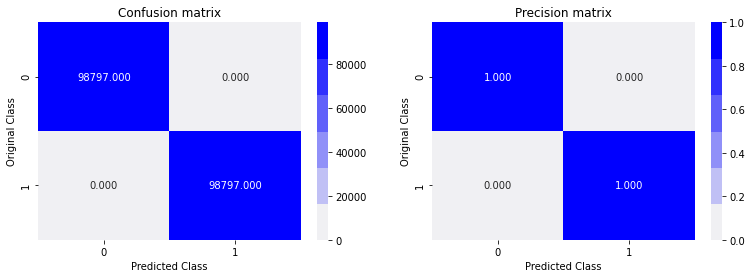

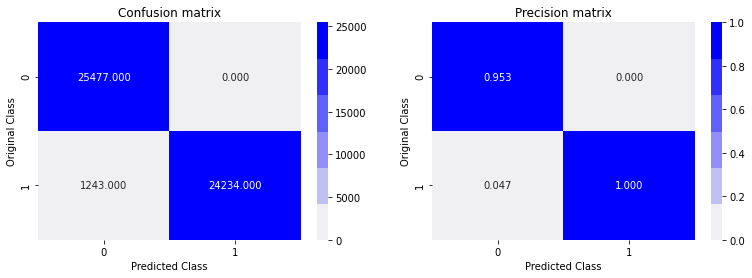

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

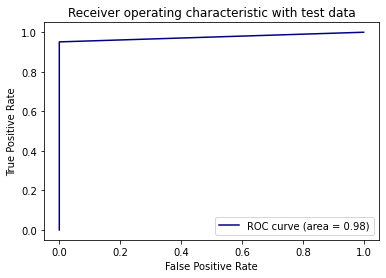

In [ ]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()



0.9878027240255918


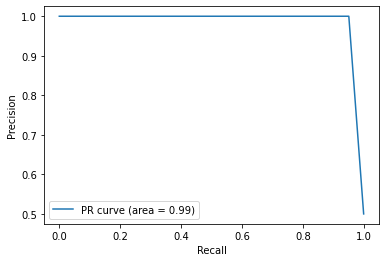

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
AUC= auc(recall, precision)
print(AUC)
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % AUC)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

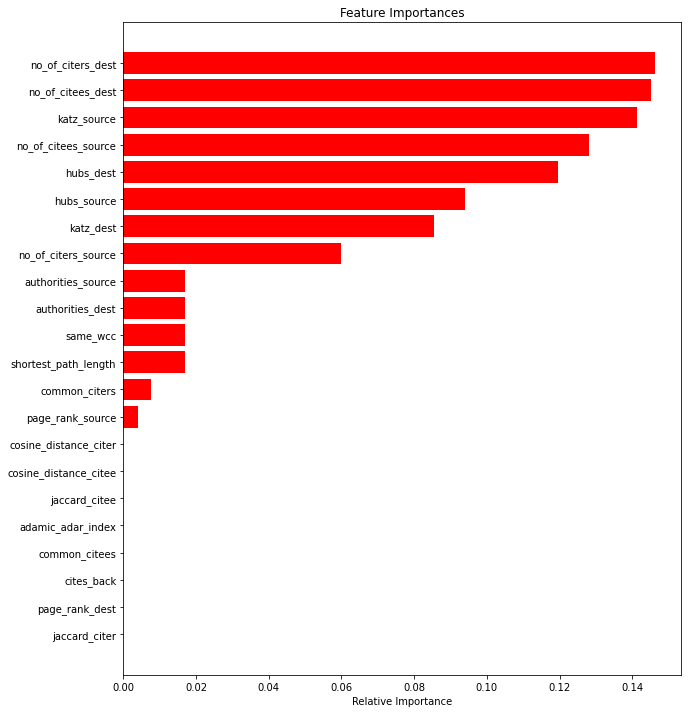

In [ ]:
#Features importances
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()